# Import

In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector, ConvLSTM1D, Flatten
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import keras
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-3, patience=8, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True)


from modules.Utils.utils import loadFromDB, strategyTester, computeStochasticLinearRegression
from modules.Utils.indicators import computeSuperTrend, addIndicators, computeLaggingLinearRegression, computeTrixIndicator, generateDatesFeatures


2022-09-23 15:44:46.324345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 15:44:46.324374: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Get data

In [2]:
SYMBOL= 'BTC'
df = loadFromDB(f'../backtest_tools/database/database/Binance/1h/{SYMBOL}-USDT.csv')#loadFromDB(f'./Data/1h/{SYMBOL}-USDT.csv')
df['Close_filtered'] = savgol_filter(df['Close'].values, 25, 2,mode='nearest')
print(f"Total records : {len(df)} rows")
df.head()

Total records : 20247 rows


,Open,High,Low,Close,Volume,Timestamp,Close_filtered
Date,,,,,,,
2020-06-01 02:00:00,9448.27,9508.57,9421.67,9498.31,1742.125917,1590969600,9520.460698
2020-06-01 03:00:00,9498.78,9570.00,9465.30,9551.58,2064.378210,1590973200,9523.895600
2020-06-01 04:00:00,9551.17,9568.61,9526.87,9530.67,1984.956728,1590976800,9527.043859
2020-06-01 05:00:00,9531.70,9571.66,9514.65,9555.79,1620.638978,1590980400,9531.252417
2020-06-01 06:00:00,9556.14,9619.00,9541.96,9549.02,2787.512219,1590984000,9533.431324


# Trying to denoise.

## Normalize data

In [3]:
WINDOW = 50
INDEXING_WINDOW = 1

df['Close_filtered_norm'] = (df.Close_filtered-df.Close_filtered.mean())/df.Close_filtered.std()
df['Close_norm'] = (df.Close-df.Close.mean())/df.Close.std()

## Train and Test training

In [4]:
#df =  df.iloc[-5000:]

X = np.array([df.Close_norm.iloc[i:i+WINDOW].values.reshape(1,-1) for i in range(len(df)-WINDOW)])[:-INDEXING_WINDOW]
y = np.array([df.Close_filtered_norm.iloc[i:i+WINDOW].values.reshape(1,-1) for i in range(len(df)-WINDOW)])[INDEXING_WINDOW:]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

(14137, 1, 50)


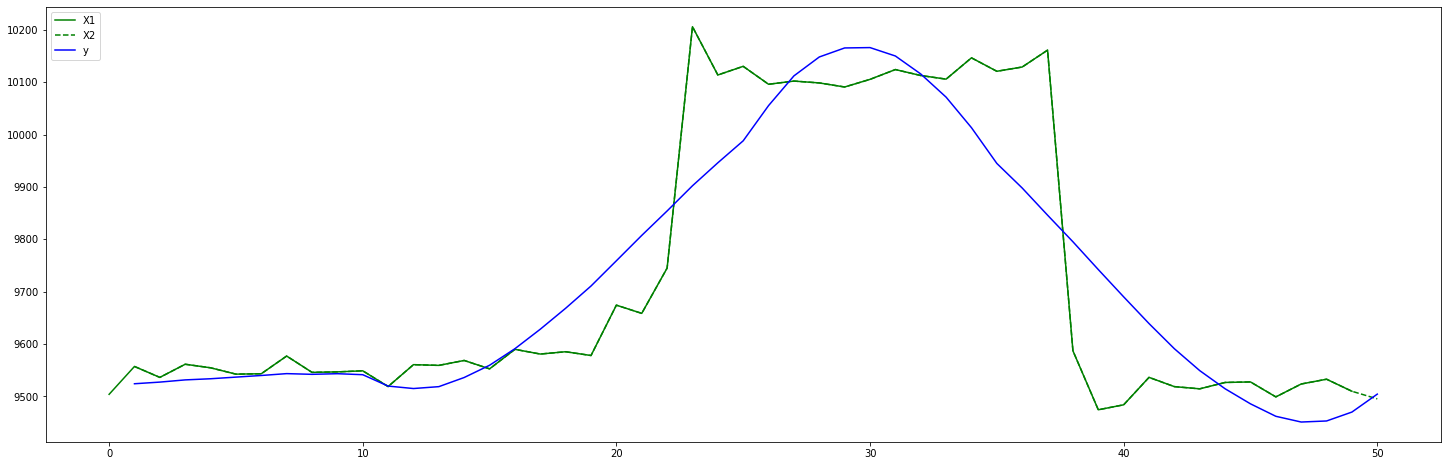

In [11]:
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_left.plot(list(range(len(X[0][0]))),X[0][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='green',label='X1')
ax_left.plot([i+INDEXING_WINDOW for i in range(len(X[INDEXING_WINDOW][0]))],X[INDEXING_WINDOW][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='green',label='X2', linestyle='--')
ax_left.plot([i+INDEXING_WINDOW for i in range(len(y[INDEXING_WINDOW][0]))],y[0][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='blue',label='y')
ax_left.legend(loc="upper left")
print(X_train.shape)

### Only dense

In [42]:
input_window = Input(shape=(1,WINDOW))
encoded = Dense(10, activation='relu')(input_window)
inter_1 = Dense(30, activation='relu')(encoded)
decoded = Dense(WINDOW, activation='linear')(inter_1)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(X, y,
                epochs=200,
                batch_size=1024,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stop])

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 100)]          0         
                                                                 
 dense_22 (Dense)            (None, 1, 10)             1010      
                                                                 
 dense_23 (Dense)            (None, 1, 30)             330       
                                                                 
 dense_24 (Dense)            (None, 1, 100)            3100      
                                                                 
Total params: 4,440
Trainable params: 4,440
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
47/47 [==============================] - 2s 22ms/step - loss: 0.6746 - val_loss: 0.0985
Epoch 2/200
47/47 [==============================] - 0s 11ms/step - loss: 0.1067 - val_l

### With LSTM

In [49]:
input_window = Input(shape=(1,WINDOW))
encoded = LSTM(4, kernel_initializer='he_uniform', return_sequences=True, name='encoder_1')(input_window)
encoded_2 = Dense(10, activation='relu',)(encoded)
norm_1 = BatchNormalization()(encoded_2)
inter_1 = Dense(30, activation='relu')(norm_1)
norm_2 = BatchNormalization()(inter_1)
decoded = Dense(WINDOW, activation='linear')(norm_2)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

history = autoencoder.fit(X, y,
                epochs=200,
                batch_size=1024,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stop])

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1, 50)]           0         
                                                                 
 encoder_1 (LSTM)            (None, 1, 4)              880       
                                                                 
 dense_15 (Dense)            (None, 1, 10)             50        
                                                                 
 batch_normalization_2 (Batc  (None, 1, 10)            40        
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 1, 30)             330       
                                                                 
 batch_normalization_3 (Batc  (None, 1, 30)            120       
 hNormalization)                                          

In [50]:
predictions = autoencoder.predict(X)
print(len(X))
print(len(predictions))

20196
20196


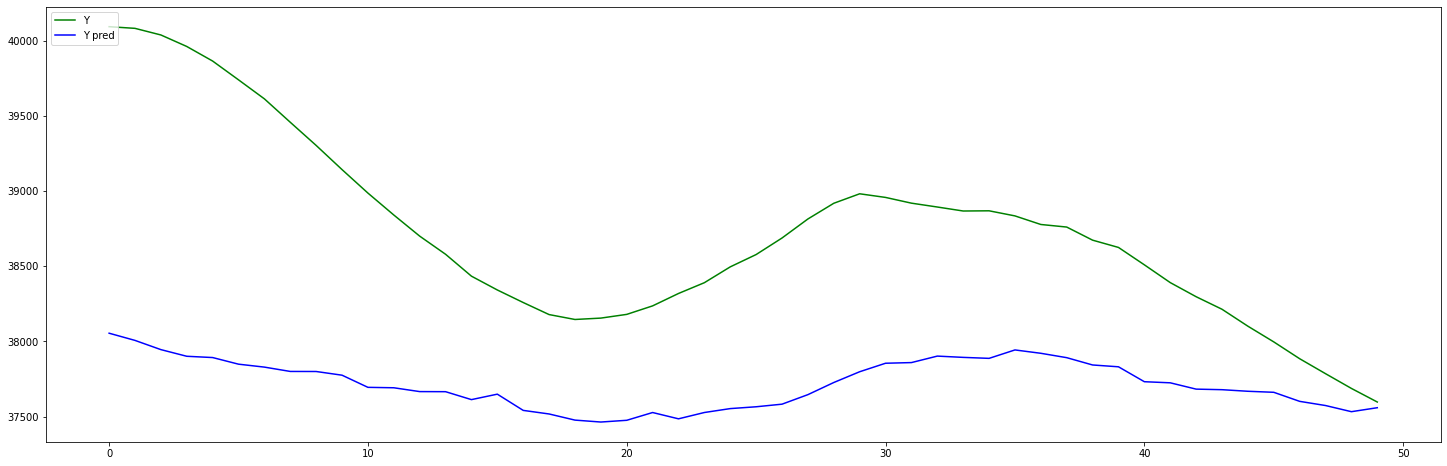

In [53]:
from random import randint
index = -randint(0,len(y)-1)

fig, ax_left = plt.subplots(1, figsize=(25,8))


ax_left.plot(list(range(len(y[index][0]))),y[index][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='green',label='Y')
ax_left.plot(list(range(len(predictions[index][0]))),savgol_filter(predictions[index][0]*df.Close_filtered.std()+df.Close_filtered.mean(), 25, 2,mode='nearest'),color='blue',label='Y pred')
ax_left.legend(loc="upper left")